In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Function to read the data
def read_data(filename):
    data = pd.read_csv(filename, header=None)
    features = data.iloc[:, :-1].values
    labels = data.iloc[:, -1].values - 1  # Shift the class labels to 0-4
    return features, labels

# Read the data
data_url = "https://raw.githubusercontent.com/UMBInal/data/main/data3.csv"
x, y = read_data(data_url)

In [4]:
x.shape

(36670, 39)

In [5]:
y.shape

(36670,)

In [6]:
np.unique(y)

array([0., 1., 2., 3., 4.])

In [7]:
x[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

In [8]:
y[0]

0.0

In [9]:
# Split the data into training, validation, and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [10]:
# Reshape the data
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [11]:
# Determine the input shape and number of classes
input_shape = (x_train.shape[1], 1)
num_classes = len(np.unique(y))

In [12]:
num_classes

5

In [13]:
input_shape

(39, 1)

In [14]:
x_train.shape

(26402, 39, 1)

In [15]:
y_train.shape

(26402,)

In [16]:
x_train[0]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [17]:
y_train[0]

0.0

In [18]:
# Transformer Encoder function with dropout and L2 regularization
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1, l2_reg=0.01):
    
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed-forward network with dropout and L2 regularization
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(res)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(inputs.shape[-1], activation = 'softmax')(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    return x + res

In [19]:
# Transformer Decoder function
def transformer_decoder(inputs, enc_outputs, head_size, num_heads, ff_dim, dropout=0.1, l2_reg=0.01):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(res, enc_outputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = x + res

    # Feed-forward network
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(inputs.shape[-1], activation = 'softmax')(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    return x + res


In [20]:
# Build the model
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0, l2_reg=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Encoder
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, l2_reg)

        
    # Decoder
    decoder_input = keras.Input(shape=input_shape)
    dec = decoder_input
    for _ in range(num_transformer_blocks):
        dec = transformer_decoder(dec, x, head_size, num_heads, ff_dim, dropout, l2_reg)

    x = layers.Flatten()(x)
    dec = layers.Flatten()(dec)
    x = layers.Concatenate()([x, dec])

    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model([inputs, decoder_input], outputs)
    return model

In [21]:
# Define the hyperparameters

head_size = 2
num_heads = 16
ff_dim = 512
num_transformer_blocks = 6
mlp_units = [512]
dropout = 0.1
mlp_dropout = 0.1
initial_lr = 0.001
l2_reg=0.01

In [22]:
model = load_model("my_model_18.h5")

In [23]:
# Create the optimizer with the initial learning rate
optimizer = Adam(learning_rate=initial_lr)

In [24]:
# Compile the model
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [25]:
# Create the ReduceLROnPlateau callback
lr_callback = ReduceLROnPlateau(factor=0.1, patience=50)

In [26]:
# Record the start time
start_time = time.time()

In [27]:
# Record the end time
end_time = time.time()

In [28]:
# Calculate the total running time
running_time = end_time - start_time
print("Total Running Time: {:.2f} seconds".format(running_time))

Total Running Time: 0.02 seconds


In [29]:
# Evaluate the model
loss, accuracy = model.evaluate([x_test, x_test], y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

115/115 [==============================] - 15s 76ms/step - loss: 0.3937 - accuracy: 0.8686
Test loss: 0.3936616778373718, Test accuracy: 0.8685573935508728


In [30]:
# Evaluate the model
y_pred = model.predict([x_test, x_test])
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

115/115 [==============================] - 12s 76ms/step


In [31]:
# Define the label mapping
label_mapping = {
    0: 'Sed.',
    1: 'LHH',
    2: 'MtV',
    3: 'Walk',
    4: 'Run'
}

In [32]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

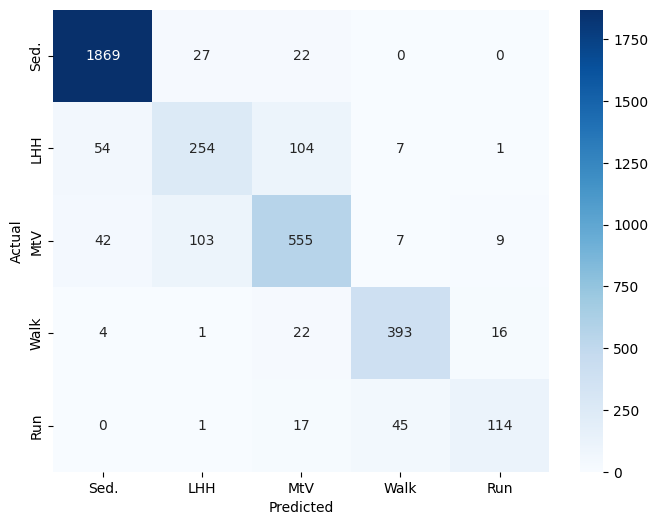

In [33]:
# Plot the confusion matrix with label names
class_names = [label_mapping[label] for label in np.unique(y)]
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [34]:
def calculate_sensitivity_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    
    sensitivity = np.zeros(num_classes)
    specificity = np.zeros(num_classes)
    
    for i in range(num_classes):
        true_positive = cm[i, i]
        false_negative = np.sum(cm[i, :]) - true_positive
        false_positive = np.sum(cm[:, i]) - true_positive
        true_negative = np.sum(cm) - true_positive - false_negative - false_positive
        
        sensitivity[i] = true_positive / (true_positive + false_negative)
        specificity[i] = true_negative / (true_negative + false_positive)
    
    sensitivity_percentage = sensitivity * 100
    specificity_percentage = specificity * 100
    
    return sensitivity_percentage, specificity_percentage

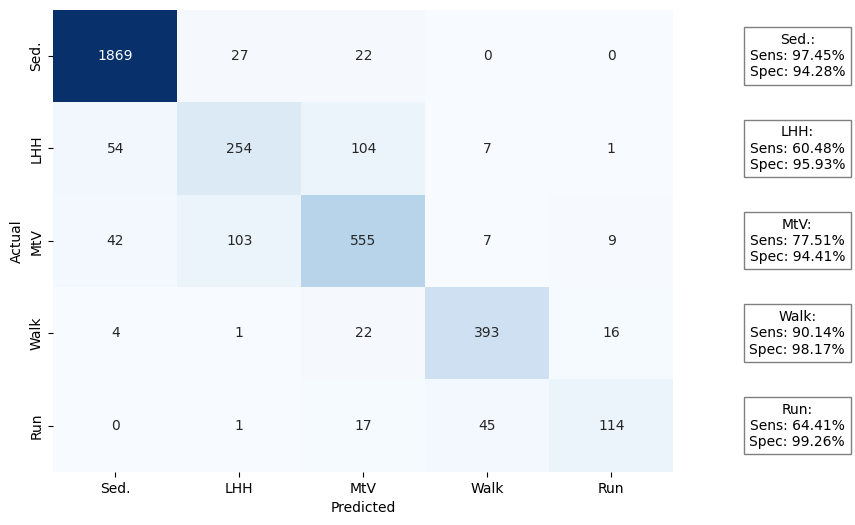

In [35]:
# Plot the confusion matrix with label names
class_names = [label_mapping[label] for label in np.unique(y)]
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names,cbar=False, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# Calculate sensitivity and specificity
sensitivity, specificity = calculate_sensitivity_specificity(y_test, y_pred)

# Display sensitivity and specificity for each class within the heatmap
for i in range(len(class_names)):
    row_start = i
    row_end = i + 1
    col_start = len(class_names)
    col_end = len(class_names) + 2
    
    ax.text((col_start + col_end) / 2, (row_start + row_end) / 2, 
            f"{class_names[i]}:\nSens: {sensitivity[i]:.2f}%\nSpec: {specificity[i]:.2f}%", 
            ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))

plt.show()